# Imports

In [35]:
# import the tools we need
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision
from torchvision.models import ResNet34_Weights, resnet34, resnet50, resnet101, resnet152
from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchmetrics import Metric, Accuracy
from torch.utils.data import random_split

# NN Variables

In [36]:
train_data_path = "../Dog_Breed_dataset/MyTrainData/"
test_data_path = "../Dog_Breed_dataset/MyTestData/"

input_dim = (224, 224)
batch_size = 64
EPOCHS = 2

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("The model will be running on", device, "device")

The model will be running on mps device


# Data

In [37]:
classes = ["Chihuahua", "Japanese_spaniel", "Maltese_dog", "Pekinese", "Shih-Tzu", "Blenheim_spaniel", "papillon", "toy_terrier", "Rhodesian_ridgeback", "Afghan_hound", "basset", "beagle", "bloodhound", "bluetick", "black-and-tan_coonhound", "Walker_hound", "English_foxhound", "redbone", "borzoi", "Irish_wolfhound", "Italian_greyhound", "whippet", "Ibizan_hound", "Norwegian_elkhound", "otterhound", "Saluki", "Scottish_deerhound", "Weimaraner", "Staffordshire_bullterrier", "American_Staffordshire_terrier", "Bedlington_terrier", "Border_terrier", "Kerry_blue_terrier", "Irish_terrier", "Norfolk_terrier", "Norwich_terrier", "Yorkshire_terrier", "wire-haired_fox_terrier", "Lakeland_terrier", "Sealyham_terrier", "Airedale", "cairn", "Australian_terrier", "Dandie_Dinmont", "Boston_bull", "miniature_schnauzer", "giant_schnauzer", "standard_schnauzer", "Scotch_terrier", "Tibetan_terrier", "silky_terrier", "soft-coated_wheaten_terrier", "West_Highland_white_terrier", "Lhasa", "flat-coated_retriever", "curly-coated_retriever", "golden_retriever", "Labrador_retriever", "Chesapeake_Bay_retriever", "German_short-haired_pointer", "vizsla", "English_setter", "Irish_setter", "Gordon_setter", "Brittany_spaniel", "clumber", "English_springer", "Welsh_springer_spaniel", "cocker_spaniel", "Sussex_spaniel", "Irish_water_spaniel", "kuvasz", "schipperke", "groenendael", "malinois", "briard", "kelpie", "komondor", "Old_English_sheepdog", "Shetland_sheepdog", "collie", "Border_collie", "Bouvier_des_Flandres", "Rottweiler", "German_shepherd", "Doberman", "miniature_pinscher", "Greater_Swiss_Mountain_dog", "Bernese_mountain_dog", "Appenzeller", "EntleBucher", "boxer", "bull_mastiff", "Tibetan_mastiff", "French_bulldog", "Great_Dane", "Saint_Bernard", "Eskimo_dog", "malamute", "Siberian_husky", "affenpinscher", "basenji", "pug", "Leonberg", "Newfoundland", "Great_Pyrenees", "Samoyed", "Pomeranian", "chow", "keeshond", "Brabancon_griffon", "Pembroke", "Cardigan", "toy_poodle", "miniature_poodle", "standard_poodle", "Mexican_hairless", "dingo", "dhole", "African_hunting_dog"]

class DogDataset(Dataset):
    def __init__(self, data_path, annotation_file, transform=None):
        self.data_path = data_path
        self.annotation_file = annotation_file
        self.df = pd.read_json(data_path + annotation_file)
        self.label_list = []
        self.transform = transform

        for i in range(len(self.df)):
            for annotation in self.df.iloc[i].annotation:
                # append annotation['label'] to label_list
                self.label_list.append(annotation['label'])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Load image and extract dog ROI
        image = plt.imread(self.data_path + self.df.iloc[idx].imagefilename)

        for annotation in self.df.iloc[idx].annotation:
            x, y, width, height = annotation['coordinates'].values()
            dog_roi = image[y:y+height, x:x+width]
            # remove alpha channel
            if dog_roi.shape[2] == 4:
                dog_roi = dog_roi[:, :, :3]
            
            dog_roi = dog_roi / 255.0
            dog_roi = torch.from_numpy(dog_roi).permute(2, 0, 1).float()

            # Apply any transformations
            if self.transform:
                dog_roi = self.transform(dog_roi)
            
            # Get the label
            label = torch.tensor(classes.index(annotation['label']))
            
            # Return a tuple of the image and label
            return dog_roi, label

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(input_dim, antialias=True),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(10),
    # torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_dataset = DogDataset(train_data_path, "train_annotation.json", transform=transform)

# Define the validation set size
val_size = 0.2

# Calculate the sizes of the train and validation datasets
train_size = len(train_dataset)
val_size = int(val_size * train_size)
train_size = train_size - val_size

# Split the train dataset into train and validation datasets
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(input_dim, antialias=True),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_dataset = DogDataset(test_data_path, "test_annotation.json", transform=transform)

# Create data loader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


# Main Training Function

In [38]:
# Print the result of 1 epoch
def print_epoch_result(train_loss,train_acc,val_loss,val_acc):
    print('loss: {:.3f}, acc: {:.3f}, val_loss: {:.3f}, val_acc: {:.3f}'.format(train_loss,
                                                                              train_acc,
                                                                              val_loss,
                                                                              val_acc))
# Main Training function
def train_model(model, cost_function, optimizer,num_epochs=5):
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    
    # Metrics object
    train_acc_object = Accuracy(task="multiclass", num_classes=120)
    val_acc_object = Accuracy(task="multiclass", num_classes=120)
    
    for epoch in range(num_epochs):
        """
        On epoch start
        """
        print('-'*15)
        print('Start training {}/{}'.format(epoch+1, num_epochs))
        print('-'*15)
        
        # Training
        train_sub_losses = []
        model.train()
        for x, y in train_dataloader:
            optimizer.zero_grad()
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            loss = cost_function(y_hat,y)
            loss.backward()
            optimizer.step()
            #lr_scheduler.step()
            # update loss sublist
            train_sub_losses.append(loss.item())
            # update accuracy object
            train_acc_object(y_hat.cpu(),y.cpu())
            
        # Validation
        val_sub_losses = []
        model.eval()
        for x,y in val_dataloader:
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            loss = cost_function(y_hat,y)
            val_sub_losses.append(loss.item())
            val_acc_object(y_hat.cpu(),y.cpu())
            
        """
        On epoch end
        """
        # Update the loss list
        train_losses.append(np.mean(train_sub_losses))
        val_losses.append(np.mean(val_sub_losses))
        
        # Update the accuracy list and reset the metrics object 
        train_epoch_acc = train_acc_object.compute()
        val_epoch_acc = val_acc_object.compute()
        train_acc.append(train_epoch_acc)
        val_acc.append(val_epoch_acc)
        train_acc_object.reset()
        val_acc_object.reset()
        
        # print the result of epoch
        print_epoch_result(np.mean(train_sub_losses),train_epoch_acc,np.mean(val_sub_losses),val_epoch_acc)
        torch.save(model.state_dict(), 'saved_models/dog_recognition_running.pt')

    print('Finish Training.')
    return train_losses, train_acc, val_losses, val_acc

In [39]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("The model will be running on", device, "device")

The model will be running on mps device


# Network Architecture

In [40]:
# Use resnet-50 as a base model
class net(torch.nn.Module):
    def __init__(self, base_model, base_out_features, num_classes):
        super(net,self).__init__()
        self.base_model=base_model
        self.linear1 = torch.nn.Linear(base_out_features, 512)
        self.output = torch.nn.Linear(512,num_classes)
    def forward(self,x):
        x = F.relu(self.base_model(x))
        x = F.relu(self.linear1(x))
        x = self.output(x)
        return x

res = torchvision.models.resnet50(pretrained=True)
# res = torchvision.models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
for param in res.parameters():
    param.requires_grad=False

model_final = net(base_model=res, base_out_features=res.fc.out_features, num_classes=120)

file_path = "Dog_reco.pt"
if os.path.exists(file_path):
    state_dict = torch.load(file_path)
    model_final.load_state_dict(state_dict)
    print(f"Loaded model state from {file_path}")
else:
    print(f"No model state found at {file_path}")

model_final = model_final.to(device)

/Users/maxencecabiddu/sfsu/semester2/appdev/neural_network/dog_recognizer_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/maxencecabiddu/sfsu/semester2/appdev/neural_network/dog_recognizer_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded model state from Dog_reco.pt


In [41]:
# Cost function and optimzier
cost_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([param for param in model_final.parameters() if param.requires_grad], lr=0.0003)

# Learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.1)

In [42]:
# Start Training
train_losses, train_acc, val_losses, val_acc = train_model(model=model_final, 
                                                           cost_function=cost_function, 
                                                           optimizer=optimizer,
                                                           num_epochs=EPOCHS)

---------------
Start training 1/1
---------------
loss: -0.864, acc: 0.895, val_loss: -0.898, val_acc: 0.923
Finish Training.


In [43]:
# Save the model
# get the current date and time
import datetime
now = datetime.datetime.now()
dt_string = now.strftime("%d%m%Y%H%M%S")
torch.save(model_final.state_dict(), 'saved_models/dog_reco_' + dt_string + '.pt')

# Plot the result

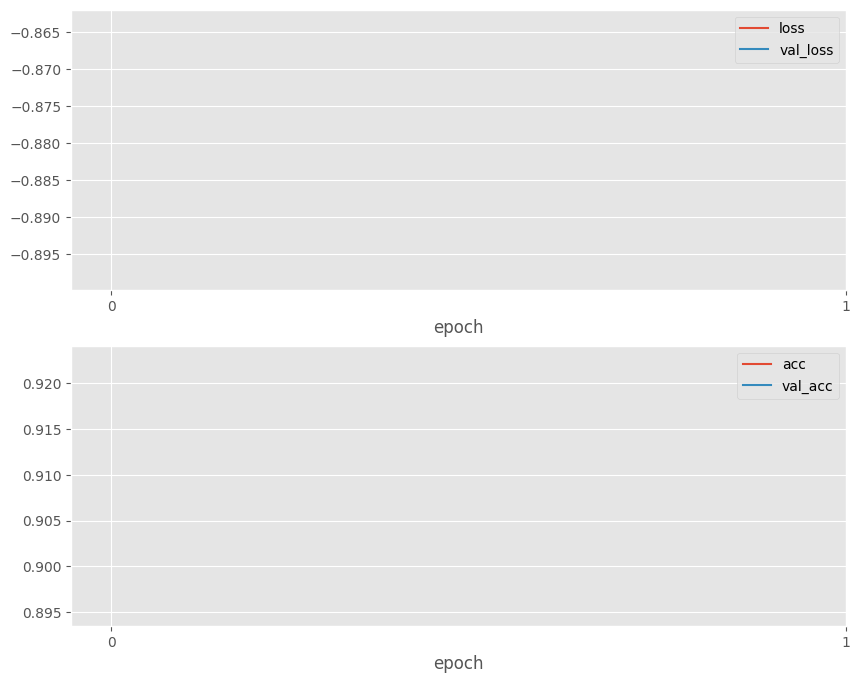

In [44]:
def plot_result(train_loss,val_loss,train_acc,val_acc):
    plt.style.use('ggplot')
    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,8))
    ax1.plot(train_loss,label='loss')
    ax1.plot(val_loss,label='val_loss')
    ax1.legend()
    ax1.set_xlabel('epoch')
    ax1.set_xticks(range(0,EPOCHS+1))
    ax2.plot(train_acc, label='acc')
    ax2.plot(val_acc,label='val_acc')
    ax2.legend()
    ax2.set_xlabel('epoch')
    ax2.set_xticks(range(0,EPOCHS+1))
    plt.show()
plot_result(train_losses,val_losses, train_acc,  val_acc)

# Do prediction on test data

In [45]:
# Compute accuracy on test set for each epoch
model_final.eval()
predictions = torch.tensor([])
test_acc_object = Accuracy(task="multiclass", num_classes=120)
for x,y in test_dataloader:
    x,y = x.to(device),y.to(device)
    y_hat = model_final(x)
    test_acc_object(y_hat.cpu(),y.cpu())
    predictions = torch.cat((predictions, y_hat.cpu()), 0)
test_acc = test_acc_object.compute()

# Print test accuracy for each epoch
print('Test accuracy = {:.2f}%'.format(test_acc*100))

Test accuracy = 80.07%


# Convert to CoreML

In [46]:
import coremltools as ct

# Load PyTorch model (and perform tracing)
torch_model = model_final.to('mps')
torch_model.eval()

example_input = test_dataloader.dataset[0][0]
example_input = example_input.unsqueeze(0).to('mps')
print(example_input.shape)
traced_model = torch.jit.trace(torch_model, example_input).to('mps')
out = traced_model(example_input)

torch.Size([1, 3, 224, 224])


In [47]:
import coremltools as ct

model = ct.convert(
    traced_model,
    convert_to='neuralnetwork',
    # inputs=[ct.TensorType(name='input', shape=example_input.shape)],
    inputs=[ct.ImageType(name='input', shape=example_input.shape, scale=1/255.0)],
    outputs=[ct.TensorType(name='output')],
    classifier_config = ct.ClassifierConfig(classes),
    compute_units=ct.ComputeUnit.ALL,
)

Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 461/461 [00:13<00:00, 33.43 ops/s] 


In [48]:
model.save("Dog_recognition_img.mlmodel")